In [1]:
#IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,roc_auc_score
from fast_ml.model_development import train_valid_test_split
import math
from math import sqrt


/home/yastaha/.local/share/virtualenvs/hw#6-3Synnf3f/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# READING DATASET:
PATH = "./housing.csv"
cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH)
df = df[cols]
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.median_house_value=np.log1p(df.median_house_value)
df=pd.get_dummies(df)
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target='median_house_value',train_size=0.6,valid_size=0.2,test_size=0.2, random_state=1)

In [15]:

#Trying out a simple decision tree with max_depth = 1

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=X_train.columns.to_list()))


|--- ocean_proximity_INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity_INLAND >  0.50
|   |--- value: [11.62]



In [88]:
#simple random forest model
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)
    print(f'rmse score with n_estimators = {n}: {np.sqrt(mean_squared_error(y_valid, y_pred)):6f}')

rmse score with n_estimators = 10: 0.249498
rmse score with n_estimators = 20: 0.242561
rmse score with n_estimators = 30: 0.239942
rmse score with n_estimators = 40: 0.239181
rmse score with n_estimators = 50: 0.238766
rmse score with n_estimators = 60: 0.237700
rmse score with n_estimators = 70: 0.238037
rmse score with n_estimators = 80: 0.237109
rmse score with n_estimators = 90: 0.236865
rmse score with n_estimators = 100: 0.236622
rmse score with n_estimators = 110: 0.236412
rmse score with n_estimators = 120: 0.236266
rmse score with n_estimators = 130: 0.236257
rmse score with n_estimators = 140: 0.235901
rmse score with n_estimators = 150: 0.235804
rmse score with n_estimators = 160: 0.235639
rmse score with n_estimators = 170: 0.235610
rmse score with n_estimators = 180: 0.235745
rmse score with n_estimators = 190: 0.235844
rmse score with n_estimators = 200: 0.235710


In [51]:
#Trying out n_estimators from 10 to 200, with step of 10 (10,20,30..190,200)
scores = []
y_pred = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


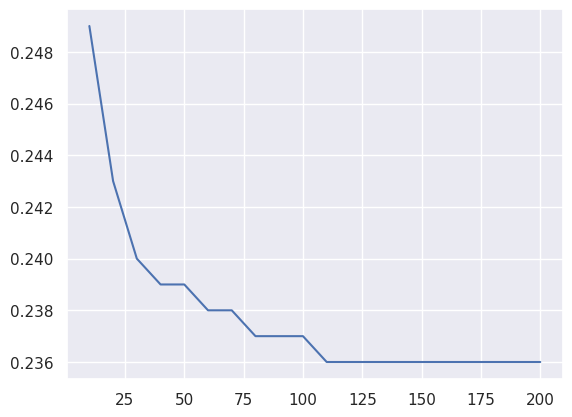

In [52]:
sns.set()
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

#rmse straightens out after 100 estimators

In [39]:
#Trying different tree depths

max_depth = [10, 15, 20, 25]
scores = []

for depth in max_depth:

    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_depth=depth)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_valid)
        score = np.sqrt(mean_squared_error(y_valid, y_pred))
     
    
        scores.append((depth, n, score))

df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])

    

100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


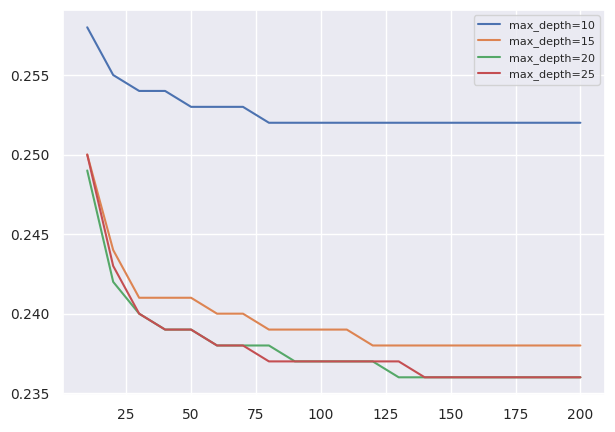

In [82]:

plt.figure(figsize=(7,5))
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for d in max_depth:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(3),
             label='max_depth=%d' % d)

# plt.xlim([125,170])
# plt.ylim([0.235998,0.2360799])
plt.legend(fontsize=8)


In [66]:
max_depth = [10, 15, 20, 25]

for d in max_depth:
    df_subset = df_scores[df_scores.max_depth == d]
    print(f'Best parameters at max_depth {d}:')
    cond= df_subset.rmse == df_subset.rmse.min()
    print(df_subset[cond].to_string(index=False))

Best parameters at max_depth 10:
 max_depth  n_estimators     rmse
        10           170 0.251683
Best parameters at max_depth 15:
 max_depth  n_estimators     rmse
        15           170 0.237998
Best parameters at max_depth 20:
 max_depth  n_estimators     rmse
        20           160 0.235799
Best parameters at max_depth 25:
 max_depth  n_estimators     rmse
        25           200 0.236003


In [86]:
#best parameters!

df_scores[df_scores.rmse == df_scores.rmse.min()]

,max_depth,n_estimators,rmse
55,20,160,0.235799


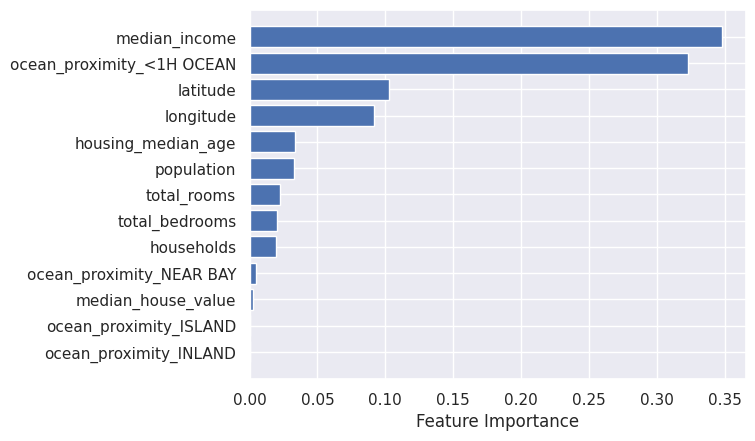

In [57]:
#feature importance

m=RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
m.fit(X_train,y_train)
sort = m.feature_importances_.argsort()
plt.barh(df.columns[sort], m.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.show()

In [ ]:
#XGboost Regressor now!

In [37]:
#Columns names changed as XGBOOST was showing error because of '<'
X_train.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_less_than_1H_OCEAN'}, inplace=True)
X_valid.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_less_than_1H_OCEAN'}, inplace=True)

In [54]:
#xgboost model with different eta values and saving rmse scores in dataframe
s=[]
for e in [0.3,0.1,0.01]:
  xgb_r=xgb.XGBRegressor(eta=e, max_depth=6,min_child_weight=1,objective='reg:squarederror', nthread=8, seed=1, verbosity=1)
  xgb_r.fit(X_train, y_train)
  y_pred = xgb_r.predict(X_valid)
  sc = np.sqrt(mean_squared_error(y_valid, y_pred))
  s.append((e, sc))

df_s = pd.DataFrame(s, columns=['eta','rmse'])

In [55]:
df_s.set_index('eta')

#Rmse at eta = 0.3 is better

,rmse
eta,
0.30,0.231603
0.10,0.235699
0.01,4.256797


In [56]:
xgb_r.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=8,
             nthread=8, num_parallel_tree=1, predictor='auto', random_state=1, ...)>